This notebook will compare RFF & RBF embedder in performance variance in 1D signal reconstruction.

In [8]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
criterion = torch.nn.MSELoss()
epochs = 2000

file_path = 'Final_3last/'

In [9]:
rgb = imread('4.2.07.tiff');im = rgb2gray(rgb);
signal = torch.from_numpy(im).type(torch.FloatTensor)

In [10]:
width = 256

# Here define the MLP
class SLP(nn.Module):
    def __init__(self,input_dim):
        super(SLP, self).__init__()
        self.fco = nn.Linear(input_dim, 1)
    def forward(self, x):
        out = self.fco(x)
        return out
    def name(self):
        return "SLP"

In [11]:
def srank_func(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    sr = (s*s).sum()/s[0]/s[0]
    return sr

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def rff_embedding(x, b):
    rffemb = torch.cat((torch.sin((2.*np.pi*x) @ b.T),torch.cos((2.*np.pi*x) @ b.T)),1)
    rffemb = rffemb/(rffemb.norm(dim=1).max())
    return rffemb

def rbf_embedding(x,dic,sig):
    rbfemb = (-0.5*(x-dic)**2/(sig**2)).exp()
    rbfemb = rbfemb/(rbfemb.norm(dim=1).max())
    return rbfemb

    

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

$N=256$

# parameters choosing

Large_D = 256
Ns = list(range(1,521,20))
bs = [1,5,10,20,50]
Nf = len(bs)
sr_ = np.zeros((Nf,len(Ns)))

for k in range(Nf):
    b = bs[k]*torch.randn((int(Large_D/2),1))
    for i in range(len(Ns)):
        x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
        sr_[k][i] = srank_func(rff_embedding(x,b))

for i in range(Nf):
    plot(Ns,sr_[i])

when $\sigma=0.005$ for gaussian, the stable rank changes as D changes

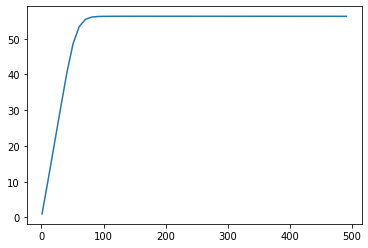

In [12]:
Large_D = 256
Ns = range(1,501,10)
sr_ = np.zeros((len(Ns)))

sig = 0.005
dic = torch.from_numpy(np.linspace(0, 1, Large_D+1)[:-1].reshape(1,-1)).type(torch.FloatTensor)
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    sr_[i] = srank_func(rbf_embedding(x,dic,sig))
plot(Ns,sr_)

In [13]:
ezs = np.linspace(100,1000,10)
E = 10
sigs = 0.005
bs = 1/2/np.sqrt(2)/np.pi/sigs
nt = 10
kk = 200
losses_ = np.zeros((E,nt,epochs))
sr_ = np.zeros((E,nt))
trn_ = np.zeros((E,nt,epochs))
tst_ = np.zeros((E,nt,epochs))

# RFF

In [14]:
sample_N = 512
sample_d = 1

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

train_data = all_data[::2*sample_d]
test_data = all_data[sample_d::2*sample_d]



for ee in range(E):
    embedding_dimension = int(ezs[ee])   
    start_time = time.time()
    for tt in range(nt):
        b = bs*torch.randn((int(embedding_dimension/2),1))

        xt = rff_embedding(train_data,b).cuda()
        xt = Variable(xt)
        xts = rff_embedding(test_data,b).cuda()

        sr_[ee,tt] = srank_func(xt.detach().cpu())

        train_label = signal[kk][::2*sample_d].reshape(-1,1)
        test_label = signal[kk][sample_d::2*sample_d].reshape(-1,1)

        yt = train_label.cuda()
        yt = Variable(yt)
        yts = test_label.cuda()


        # Initialize classification model to learn
        model = SLP(int(embedding_dimension)).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            out = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            losses_[ee,tt,epoch] = loss.item() # Store the loss
            optimizer.step()


            model.eval()

            trn_[ee,tt,epoch] = psnr_func(model(xt),yt)
            tst_[ee,tt,epoch] = psnr_func(model(xts),yts)

    print("==>>> ez: %g, train psnr: %g--- , test psnr: %g--- %g seconds ---" 
    % (embedding_dimension, np.mean(trn_[ee,:,-100:]),np.mean(tst_[ee,:,-100:])
       ,time.time() - start_time))

==>>> ez: 100, train psnr: 20.5118--- , test psnr: 20.5009--- 27.8566 seconds ---
==>>> ez: 200, train psnr: 26.393--- , test psnr: 26.3675--- 29.7286 seconds ---
==>>> ez: 300, train psnr: 27.4524--- , test psnr: 27.4258--- 26.1298 seconds ---
==>>> ez: 400, train psnr: 27.8292--- , test psnr: 27.6848--- 28.9524 seconds ---
==>>> ez: 500, train psnr: 28.167--- , test psnr: 27.9409--- 29.6287 seconds ---
==>>> ez: 600, train psnr: 28.6292--- , test psnr: 28.2726--- 28.6859 seconds ---
==>>> ez: 700, train psnr: 28.6164--- , test psnr: 28.2354--- 28.4447 seconds ---
==>>> ez: 800, train psnr: 28.8031--- , test psnr: 28.4545--- 28.7645 seconds ---
==>>> ez: 900, train psnr: 28.9566--- , test psnr: 28.4836--- 28.0995 seconds ---
==>>> ez: 1000, train psnr: 28.8245--- , test psnr: 28.2653--- 29.9356 seconds ---


Text(0, 0.5, 'stable rank')

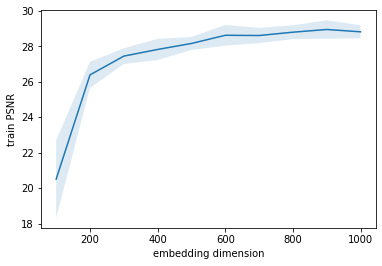

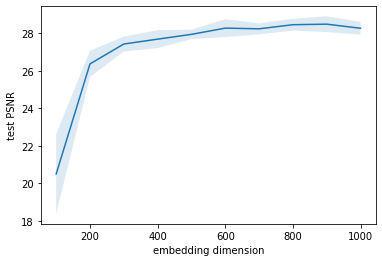

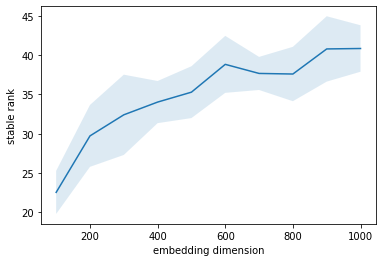

In [15]:
trn_tmp = np.mean(trn_[:,:,-100:],-1)
tst_tmp = np.mean(tst_[:,:,-100:],-1)
sr_tmp = sr_[:,:]

trn_mean = np.mean(trn_tmp,-1)
trn_std = np.std(trn_tmp,-1)
tst_mean = np.mean(tst_tmp,-1)
tst_std = np.std(tst_tmp,-1)
sr_mean = np.mean(sr_tmp,-1)
sr_std = np.std(sr_tmp,-1)

figure()
plot(ezs,trn_mean)
plt.fill_between(ezs, trn_mean-trn_std, trn_mean+trn_std, alpha=.15)
xlabel('embedding dimension')
ylabel('train PSNR')

figure()
plot(ezs,tst_mean)
plt.fill_between(ezs, tst_mean-tst_std, tst_mean+tst_std, alpha=.15)

xlabel('embedding dimension')
ylabel('test PSNR')

figure()
plot(ezs,sr_mean)
plt.fill_between(ezs, sr_mean-sr_std, sr_mean+sr_std, alpha=.15)
xlabel('embedding dimension')
ylabel('stable rank')

file_name = 'rff'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_)
np.save(file_path+file_name+'_tst',tst_)
np.save(file_path+file_name+'_emb',emb_)

# Gaussian

In [16]:
losses_g = np.zeros((E,nt,epochs))
sr_g = np.zeros((E,nt))
trn_g = np.zeros((E,nt,epochs))
tst_g = np.zeros((E,nt,epochs))

In [17]:
sample_N = 512
sample_d = 1

all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)

train_data = all_data[::2*sample_d]
test_data = all_data[sample_d::2*sample_d]


for ee in range(E):
    embedding_dimension = int(ezs[ee])
    start_time = time.time()
    
    print('ez = {}'.format(embedding_dimension))
    dic = torch.zeros((1,embedding_dimension))
    for i in range(embedding_dimension):
        dic[0,i] = i/embedding_dimension
    for tt in range(nt):
        sig = sigs*torch.ones((1,embedding_dimension))
        
        
        xt = rbf_embedding(train_data,dic,sig).cuda()
        xt = Variable(xt)
        xts = rbf_embedding(test_data,dic,sig).cuda()
        
        sr_g[ee,tt] = srank_func(xt.detach().cpu())

        train_label = signal[kk][::2*sample_d].reshape(-1,1)
        test_label = signal[kk][sample_d::2*sample_d].reshape(-1,1)

        yt = train_label.cuda()
        yt = Variable(yt)
        yts = test_label.cuda()


        # Initialize classification model to learn
        model = SLP(int(embedding_dimension)).cuda()

        # Set the optimization
        optimizer = optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999),weight_decay=1e-8)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            out = model(xt)
            loss = criterion(out, yt)
            loss.backward()
            losses_g[ee,tt,epoch] = loss.item() # Store the loss
            optimizer.step()


            model.eval()

            trn_g[ee,tt,epoch] = psnr_func(model(xt),yt)
            tst_g[ee,tt,epoch] = psnr_func(model(xts),yts)

    print("==>>> ez: %g, train psnr: %g--- , test psnr: %g--- %g seconds ---" 
    % (embedding_dimension, np.mean(trn_[ee,:,-100:]),np.mean(tst_[ee,:,-100:])
       ,time.time() - start_time))

ez = 100
==>>> ez: 100, train psnr: 20.5118--- , test psnr: 20.5009--- 23.6688 seconds ---
ez = 200
==>>> ez: 200, train psnr: 26.393--- , test psnr: 26.3675--- 23.8657 seconds ---
ez = 300
==>>> ez: 300, train psnr: 27.4524--- , test psnr: 27.4258--- 23.825 seconds ---
ez = 400
==>>> ez: 400, train psnr: 27.8292--- , test psnr: 27.6848--- 23.8759 seconds ---
ez = 500
==>>> ez: 500, train psnr: 28.167--- , test psnr: 27.9409--- 23.8771 seconds ---
ez = 600
==>>> ez: 600, train psnr: 28.6292--- , test psnr: 28.2726--- 27.8591 seconds ---
ez = 700
==>>> ez: 700, train psnr: 28.6164--- , test psnr: 28.2354--- 30.2697 seconds ---
ez = 800
==>>> ez: 800, train psnr: 28.8031--- , test psnr: 28.4545--- 30.1618 seconds ---
ez = 900
==>>> ez: 900, train psnr: 28.9566--- , test psnr: 28.4836--- 30.2193 seconds ---
ez = 1000
==>>> ez: 1000, train psnr: 28.8245--- , test psnr: 28.2653--- 30.3055 seconds ---


Text(0, 0.5, 'stable rank')

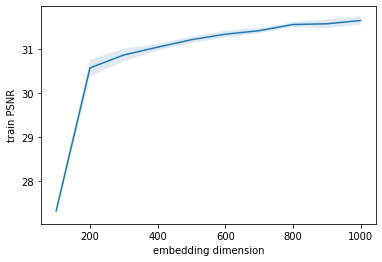

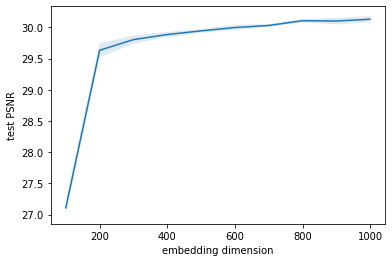

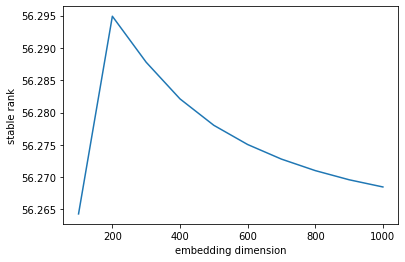

In [18]:
trn_tmp_g = np.mean(trn_g[:,:,-100:],-1)
tst_tmp_g = np.mean(tst_g[:,:,-100:],-1)
sr_tmp_g = sr_g[:,:]

trn_mean = np.mean(trn_tmp_g,-1)
trn_std = np.std(trn_tmp_g,-1)
tst_mean = np.mean(tst_tmp_g,-1)
tst_std = np.std(tst_tmp_g,-1)
sr_mean = np.mean(sr_tmp_g,-1)
sr_std = np.std(sr_tmp_g,-1)

figure()
plot(ezs,trn_mean)
plt.fill_between(ezs, trn_mean-trn_std, trn_mean+trn_std, alpha=.15)
xlabel('embedding dimension')
ylabel('train PSNR')

figure()
plot(ezs,tst_mean)
plt.fill_between(ezs, tst_mean-tst_std, tst_mean+tst_std, alpha=.15)

xlabel('embedding dimension')
ylabel('test PSNR')

figure()
plot(ezs,sr_mean)
plt.fill_between(ezs, sr_mean-sr_std, sr_mean+sr_std, alpha=.15)
xlabel('embedding dimension')
ylabel('stable rank')

file_name = 'rbf'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_)
np.save(file_path+file_name+'_tst',tst_)
np.save(file_path+file_name+'_emb',emb_)

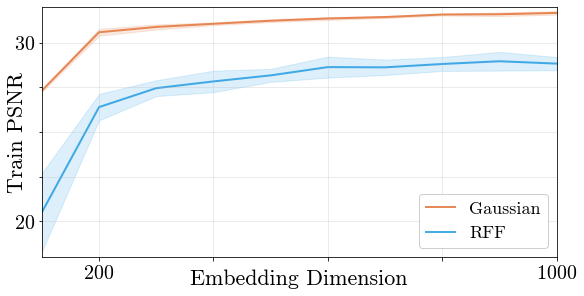

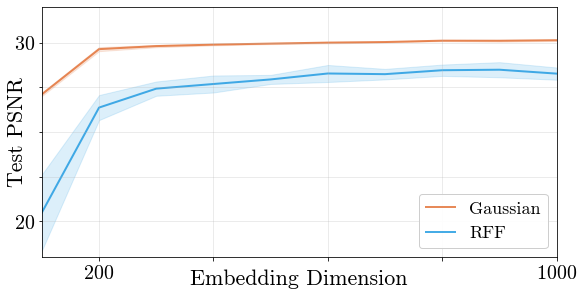

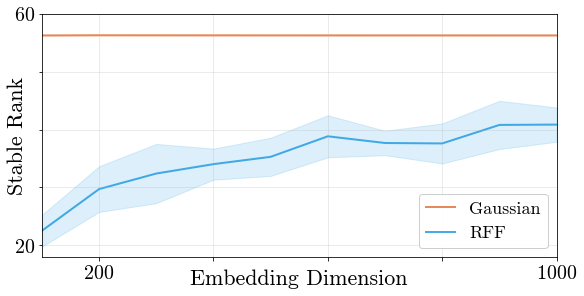

In [31]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     #[0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 2
line_alpha = .8
title_offset = -0.2

names = ['Gaussian','RFF']
file_path = 'images/'

trn_tmp = np.mean(trn_[:,:,-100:],-1)
tst_tmp = np.mean(tst_[:,:,-100:],-1)
sr_tmp = sr_[:,:]

trn_mean = np.mean(trn_tmp,-1)
trn_std = np.std(trn_tmp,-1)
tst_mean = np.mean(tst_tmp,-1)
tst_std = np.std(tst_tmp,-1)
sr_mean = np.mean(sr_tmp,-1)
sr_std = np.std(sr_tmp,-1)

trn_tmp_g = np.mean(trn_g[:,:,-100:],-1)
tst_tmp_g = np.mean(tst_g[:,:,-100:],-1)
sr_tmp_g = sr_g[:,:]

trn_mean_g = np.mean(trn_tmp_g,-1)
trn_std_g = np.std(trn_tmp_g,-1)
tst_mean_g = np.mean(tst_tmp_g,-1)
tst_std_g = np.std(tst_tmp_g,-1)
sr_mean_g = np.mean(sr_tmp_g,-1)
sr_std_g = np.std(sr_tmp_g,-1)



fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])

ax.plot(ezs,trn_mean_g,label=names[0],color=colors_k[0], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, trn_mean_g-trn_std_g, trn_mean_g+trn_std_g,color=colors_k[0], alpha=.15)
ax.plot(ezs,trn_mean,label=names[1],color=colors_k[2], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, trn_mean-trn_std, trn_mean+trn_std,color=colors_k[2], alpha=.15)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([18,32])
ax.set_yticks(np.linspace(20,30,5))
ax.set_yticklabels(['$20$','','','','$30$'])
ax.set_xticks([200,600,400,800,1000])
ax.set_xticklabels(['$200$','','','','$1000$'])
plt.xlabel('Embedding Dimension', labelpad=-13)
plt.ylabel('Train PSNR', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='lower right',  ncol=1, framealpha=.95, handlelength=1.6)
#ax.set_title('(a) Stable Rank', y=title_offset)

plt.savefig(file_path+'Error_bar_Train.pdf', bbox_inches='tight', pad_inches=0)


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])

ax.plot(ezs,tst_mean_g,label=names[0],color=colors_k[0], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, tst_mean_g-tst_std_g, tst_mean_g+tst_std_g,color=colors_k[0], alpha=.15)
ax.plot(ezs,tst_mean,label=names[1],color=colors_k[2], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, tst_mean-tst_std, tst_mean+tst_std,color=colors_k[2], alpha=.15)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([18,32])
ax.set_yticks(np.linspace(20,30,5))
ax.set_yticklabels(['$20$','','','','$30$'])
ax.set_xticks([200,600,400,800,1000])
ax.set_xticklabels(['$200$','','','','$1000$'])
plt.xlabel('Embedding Dimension', labelpad=-13)
plt.ylabel('Test PSNR', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='lower right',  ncol=1, framealpha=.95, handlelength=1.6)
#ax.set_title('(a) Stable Rank', y=title_offset)

plt.savefig(file_path+'Error_bar_Test.pdf', bbox_inches='tight', pad_inches=0)


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])

ax.plot(ezs,sr_mean_g,label=names[0],color=colors_k[0], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, sr_mean_g-sr_std_g, sr_mean_g+sr_std_g,color=colors_k[0], alpha=.15)
ax.plot(ezs,sr_mean,label=names[1],color=colors_k[2], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.fill_between(ezs, sr_mean-sr_std, sr_mean+sr_std,color=colors_k[2], alpha=.15)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks(np.linspace(20,60,5))
ax.set_yticklabels(['$20$','','','','$60$'])
ax.set_xticks([200,600,400,800,1000])
ax.set_xticklabels(['$200$','','','','$1000$'])
plt.xlabel('Embedding Dimension', labelpad=-13)
plt.ylabel('Stable Rank', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='lower right',  ncol=1, framealpha=.95, handlelength=1.6)
#ax.set_title('(a) Stable Rank', y=title_offset)

plt.savefig(file_path+'Error_bar_SR.pdf', bbox_inches='tight', pad_inches=0)